## Feature Engineering

Now that we have cleaned and done some exploration of our Ames, Iowa homes __[data](https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt)__, we will look into doing some feature engineering. Below, we will load in the data and necessary packages needed.

In [795]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv(r"C:\Users\kenp8\Documents\ames_homes_proj\Ames Home data cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2930 non-null   int64  
 1   MS SubClass      2930 non-null   int64  
 2   MS Zoning        2930 non-null   object 
 3   Lot Frontage     2930 non-null   float64
 4   Lot Area         2930 non-null   int64  
 5   Street           2930 non-null   object 
 6   Lot Shape        2930 non-null   object 
 7   Land Contour     2930 non-null   object 
 8   Utilities        2930 non-null   object 
 9   Lot Config       2930 non-null   object 
 10  Land Slope       2930 non-null   object 
 11  Neighborhood     2930 non-null   object 
 12  Condition 1      2930 non-null   object 
 13  Condition 2      2930 non-null   object 
 14  Bldg Type        2930 non-null   object 
 15  House Style      2930 non-null   object 
 16  Overall Qual     2930 non-null   int64  
 17  Overall Cond  

We saw in our EDA, that the square footage was highly correlated to `SalePrice`. `Gr Liv Area` currently provides the most information regarding square footage. We will improve on this by creating our first feature, `liveable_sf`.  We will add up all the square footage (`Gr Liv Area`, `Total Bsmt SF`) and subtract the `Low Qual Fin SF` and the `Bsmt Unf SF`. In the absence of a SME, we will use information from __[Opendoor](https://www.opendoor.com/w/blog/factors-that-influence-home-value)__ and add in 70% of the basement square footage. We will also look at both scatter plots to verify we have improved the square footage feature. Other square footage columns were considered for this feature. However, in the absence of local knowledge or a subject matter expert, the wood deck and porch square footage columns were not included here.

In [796]:
#establishing total liveable square footage feature
df['liveable_sf'] = df['Gr Liv Area'] + .7*(df['Total Bsmt SF'] - df['Bsmt Unf SF']) - df['Low Qual Fin SF'] 

Text(0, 0.5, 'Sale Price')

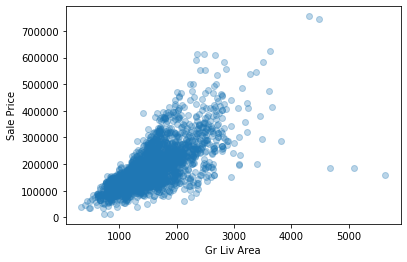

In [797]:
#scatter before creating feature
plt.scatter(df['Gr Liv Area'], df['SalePrice'], alpha =.3)
plt.xlabel('Gr Liv Area')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

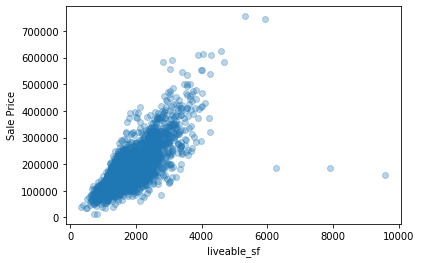

In [798]:
#scatter after square footage feature
plt.scatter(df['liveable_sf'], df['SalePrice'], alpha =.3)
plt.xlabel('liveable_sf')
plt.ylabel('Sale Price')

Text(0, 0.5, 'Sale Price')

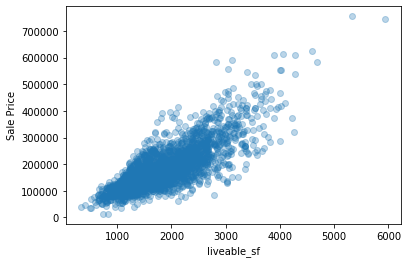

In [799]:
#dropping the 3 outlier columns
df = df[df['liveable_sf'] < 6000].copy()

#examine scatter again
plt.scatter(df['liveable_sf'], df['SalePrice'], alpha =.3)
plt.xlabel('liveable_sf')
plt.ylabel('Sale Price')

In [800]:
#checking numeric correlation
df_sf = df[['Gr Liv Area', 'liveable_sf', 'SalePrice']]
df_sf.corr()['SalePrice']

Gr Liv Area    0.727122
liveable_sf    0.795508
SalePrice      1.000000
Name: SalePrice, dtype: float64

We can see above both visually and numerically we have improved our correlation with our new square footage feature. Now we will need to drop all the columns that deal with square footage of the home.

In [801]:
old_sf_features = ['Gr Liv Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
                  '2nd Flr SF', 'Low Qual Fin SF']
df = df.drop(old_sf_features, axis=1)

Next we will create a `bath_total` feature. We will not be using the 70% factor in basement bathrooms, according to __[National Post](https://nationalpost.com/life/homes/adding-value-convenience-with-basement-bathroom)__ a basement bathroom may even add more to the `SalePrice` than an above ground restroom. We will consider a basement bathroom an equivalent contributor to the home value as an above ground restroom would. Also, according to __[thetruthaboutrealty.com](https://www.thetruthaboutrealty.com/half-bath-vs-full-bath-wheres-the-value/)__ the percentage value a full bath adds to the home value is nearly twice that of a half bath, so we will consider this to be the case. There were some outliers in the number of bathrooms. We had a small amount of our data, less than 1.8% indicating a bathroom count of 4 or higher. We are trying to generalize our model and the small percentage of homes with more than 3.5 bathrooms is small, with their sale prices not significantly affected by the large number of bathrooms. Therefore, we will put a maximum for bathroom count at 3.5 for our model creation.

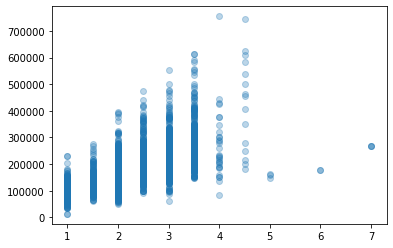

In [802]:
#establishing bathroom total feature
df['bath_total'] = df['Full Bath'] + + df['Bsmt Full Bath'] + .5*(df['Half Bath']  + df['Bsmt Half Bath'])
plt.scatter(df['bath_total'], df['SalePrice'], alpha=.3)

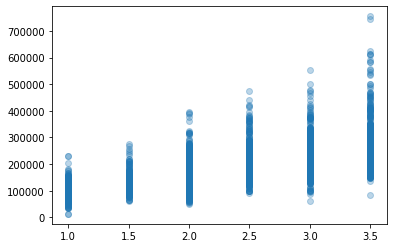

In [803]:
#setting bath_total max at 3.5
df.loc[df['bath_total'] >= 4, 'bath_total'] = 3.5
plt.scatter(df['bath_total'], df['SalePrice'], alpha=.3)

In [804]:
#dropping bath count columns from df
old_bath_cols = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath']
df = df.drop(old_bath_cols, axis=1)

Like the `bath_total` column we will make a similar maximum for the `Fireplaces` column.

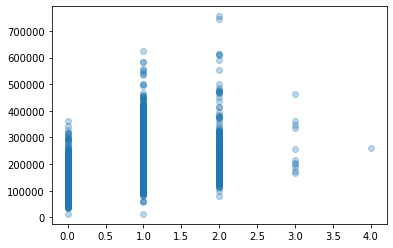

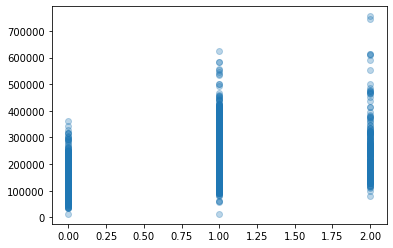

In [805]:
#setting max fireplaces = 2
plt.scatter(df['Fireplaces'], df['SalePrice'], alpha = .3)
plt.show()

df.loc[df['Fireplaces'] >= 3, 'Fireplaces'] = 2.0

plt.scatter(df['Fireplaces'], df['SalePrice'], alpha = .3)
plt.show()

Next we will want to establish an `effective_age` column for our model. To do this, we need to establish both `house_age` as well as `years_since_remodel` columns. We will look for negative values. After that we will examine the correlations to `SalePrice` and the scatter plots both before and after.

In [806]:
#creating overall age of home column
df['house_age'] = df['Yr Sold'] - df['Year Built']

#check for negative values
df['house_age'].min()

0

In [807]:
#creating column for years since remodel
df['years_since_remod'] = df['Yr Sold'] - df['Year Remod/Add']

#check for negative values
df[df['years_since_remod'] < 0]

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,liveable_sf,bath_total,house_age,years_since_remod
1702,528120010,60,RL,134.0,16659,Pave,IR1,Lvl,AllPub,Corner,...,0,6,2007,New,Partial,260116,2152.0,2.5,0,-1


In [808]:
#setting negative value = 0
df.loc[df['years_since_remod'] < 0, 'years_since_remod'] = 0

In [809]:
df_age = df[['years_since_remod', 'house_age', 'SalePrice']]
df_age.corr()['SalePrice'].abs()

years_since_remod    0.535385
house_age            0.559407
SalePrice            1.000000
Name: SalePrice, dtype: float64

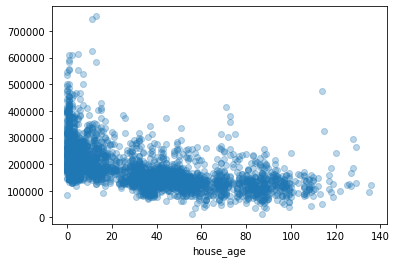

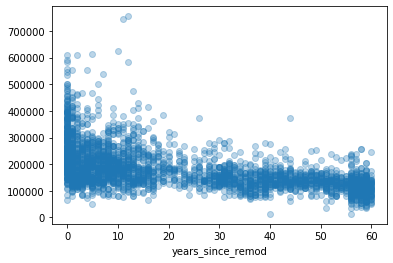

In [810]:
#examine scatter plot house age and years since remodel
age_cols =['house_age','years_since_remod']
for col in age_cols:
    plt.scatter(df_age[col], df_age['SalePrice'], alpha =.3)
    plt.xlabel(col)
    plt.show()

Now that we have both the house's original age and the years since the remodel we can establish an `effective_age` column. We will do this by taking the houses original build date for the percentage of the house that has not been remodeled. We will then add in the percentage of the house that was remodeled at the "younger" age to give us an approximation for the __[effective age](https://www.corelogic.com/blog/2016/11/effective-age-versus-actual-age.aspx)__. 

To calculate the percentage of homes that have been remodeled we made some assumptions. First we calculated a mean cost of 35 dollars US/square foot to remodel in 2020 from __[homeadvisor](https://www.homeadvisor.com/cost/additions-and-remodels/remodel-multiple-rooms/)__ . Next, we found the mean amount spent on remodeling in 2020 from the same site to be 46,785 dollars US. We used that to calculate an average remodel square footage of approximately 1337 square feet, then we divided by the average home size of 2464 square feet using data from __[MReport](https://themreport.com/daily-dose/12-10-2019/smaller-home-sizes-to-become-the-norm-in-2020)__. This, at least, gives us a snapshot of what the average percentage of a home remodeled in 2020 in the US was. It would likely vary some year to year and by region. There were a lot of assumptions made here, but it will get us closer to our goal of finding an effective age for price estimation.

In [811]:
#no remodel effective age is same as house age
df.loc[df['house_age'] == df['years_since_remod'], 'effective_age'] = df['house_age']

#calculating effective age for homes with remodel
df.loc[df['house_age'] != df['years_since_remod'], 'effective_age'] = .458 *df['house_age'] + .542 * df['years_since_remod']

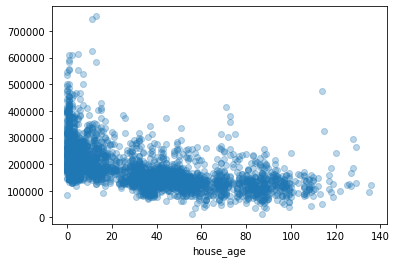

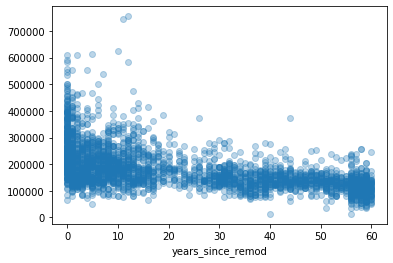

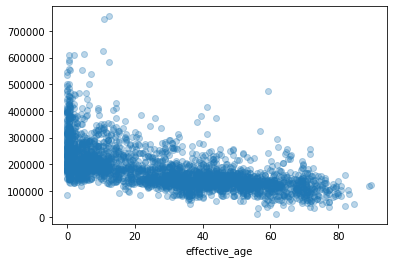

In [812]:
df_age = df_age.assign(effective_age=pd.Series(df['effective_age']).values)
age_cols.append('effective_age')

for col in age_cols:
    plt.scatter(df_age[col], df_age['SalePrice'], alpha =.3)
    plt.xlabel(col)
    plt.show()

In [813]:
df_age.corr()['SalePrice'].abs()

years_since_remod    0.535385
house_age            0.559407
SalePrice            1.000000
effective_age        0.610178
Name: SalePrice, dtype: float64

We can see we have improved the correlation of the `SalePrice` to the house's age with this new feature. However, we can also see that it does not account for the varied prices of newer homes very well. Now we will drop the columns we no longer need for home age.

In [814]:
#removing age columns no longer needed
old_age_cols = ['Year Built', 'Year Remod/Add', 'house_age', 'years_since_remod']
df = df.drop(old_age_cols, axis=1)

We have created three new features from our existing columns. To prepare for modeling we will also drop the columns here that are not useful for machine learning, those that leak information about the final sale, those with low variance and those with low correlation.

In [815]:
#drop columns not useful for Ml
df = df.drop(['PID'], axis=1)

#drop columns that leak info about final sale
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

In [816]:
#dropping nonunique or low variance columns
#keeping BsmtFin Type 1, MS Subclass, Kitchen Qual, House Style, exterior 1st and exterior 2nd for now
#dropping possible Garage Finish and Heating QC
drop_no_unique = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 
                  'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Functional', 'Garage Finish',
                  'Garage Qual','Garage Cond', 'Paved Drive', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config', 
                  'Condition 1', 'Condition 2', 'Bldg Type', 'Roof Style', 'Roof Matl', 'Mas Vnr Type','Foundation',
                  'Heating', 'Central Air', 'Garage Type', 'Kitchen AbvGr', 'TotRms AbvGrd']

drop_low_corr = ['3Ssn Porch', 'Pool Area', 'Screen Porch', 'Enclosed Porch', 'Bedroom AbvGr', 'Garage Yr Blt', 'Lot Area',
                 'Open Porch SF', 'Wood Deck SF', 'Lot Frontage']

df = df.drop(drop_no_unique, axis=1)
df = df.drop(drop_low_corr, axis=1)

We currently have 17 columns to use in our model for tuning.

In [818]:
#turning featured/transformed df into a csv
#df.to_csv('ames_homes_transformed.csv', index=False)

In [819]:
#checking
#pd.read_csv('ames_homes_transformed.csv')

,MS SubClass,Neighborhood,House Style,Overall Qual,Exterior 1st,Exterior 2nd,Mas Vnr Area,BsmtFin Type 1,Kitchen Qual,Fireplaces,Garage Cars,Garage Area,Misc Val,SalePrice,liveable_sf,bath_total,effective_age
0,20,NAmes,1Story,6,BrkFace,Plywood,112.0,BLQ,TA,2.0,2.0,528.0,0,215000,2103.3,2.0,50.000
1,20,NAmes,1Story,5,VinylSd,VinylSd,0.0,Rec,TA,0.0,1.0,730.0,0,105000,1324.4,1.0,49.000
2,20,NAmes,1Story,6,Wd Sdng,Wd Sdng,108.0,ALQ,Gd,0.0,1.0,312.0,12500,172000,1975.1,1.5,52.000
3,20,NAmes,1Story,7,BrkFace,BrkFace,0.0,ALQ,Ex,2.0,2.0,522.0,0,244000,2855.5,3.5,42.000
4,60,Gilbert,2Story,5,VinylSd,VinylSd,0.0,GLQ,TA,1.0,2.0,482.0,0,189900,2182.7,2.5,12.458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,80,Mitchel,SLvl,6,HdBoard,HdBoard,0.0,GLQ,TA,0.0,2.0,588.0,0,142500,1576.3,2.0,22.000
2923,20,Mitchel,1Story,5,HdBoard,HdBoard,0.0,BLQ,TA,0.0,2.0,484.0,0,131000,1339.5,2.0,23.000
2924,85,Mitchel,SFoyer,5,HdBoard,Wd Shng,0.0,GLQ,TA,0.0,0.0,0.0,700,132000,1205.9,1.5,14.000
2925,20,Mitchel,1Story,5,HdBoard,HdBoard,0.0,ALQ,TA,1.0,2.0,418.0,0,170000,2224.8,2.0,31.458
